In [1]:
import matplotlib.pyplot as plt
import numpy as np
from cascadoc.blocks.concentrated_blocks.fun_block import FunBlock, ON_T, ON_S
from cascadoc.blocks.distributed_blocks.hyp_block import HypBlock

# Постановка задачи

In [2]:
G11_true = lambda t: - 4*np.cos(t) / (np.cos(t)-4*np.sin(t))
G22_true = lambda t: - (np.sin(t)) / (np.cos(t) - 4* np.sin(t))

x0 = lambda s: 0
y0 = lambda s: (3*s+1)/(2*(s+1))

x_an = lambda s, t: 2*(s**2+1)*np.sin(t)
y_an = lambda s, t: (3*s+1)/(2*(s+1))*np.cos(t)
T = [0, 0.2]
S = [0, 1]
C = [1,2]

B11 = lambda s, t: -2*s
B12 = lambda s, t: 4/3*s**2
B21 = lambda s, t: - (3*s+1)/(4*(s**2+1)*(s+1))
B22 = lambda s, t: 4/((s+1)*(3*s+1))



F1 = lambda s, t: 4*s**3*np.sin(t)+2*np.cos(t)+4*s**2*np.cos(t)/(3*(s+1))
F2 = lambda s, t: 0


s0, s1 = S
t0, t1 =T
c1, c2 = C
h=0.052


hyp = HypBlock("hyp", S0=s0, S1=s1, T0=t0, T1=t1, C1=c1, C2=c2, h=h, m=None)

# Разделение узлов на граничные

In [3]:
hyp_mesh = hyp.get_mesh()

import math
eps = 1e-10

def is_int(i):
    return abs(round(i)-i) < eps

left_x = []
left_y = []
right_x = []
right_y = []
start_x = []
start_y = []
final_x = []
final_y = []

center_node = []
for node in hyp_mesh:
    i, j = node['ind']
    if node['t'] == t0:
        if is_int(j):
            start_x.append(node)
        elif is_int(i):
            start_y.append(node)
        else:
            print(i, j)
    elif node['s'] == s0:
        
        if is_int(j):
            left_x.append(node)
        elif is_int(i):
            left_y.append(node)
        else:
            print(i, j)
    elif node['s'] == s1:
        if is_int(j):
            right_x.append(node)
        elif is_int(i):
            right_y.append(node)
        else:
            print(i, j)
    elif node['t'] == t1:
        if is_int(j):
            final_x.append(node)
        elif is_int(i):
            final_y.append(node)
        else:
            print(i, j)
    else:
        center_node.append(node)

# Создание блоков на границах для работы

In [4]:
mesh = [(n['t'], int(n['ind'][1])) for n in left_y]
mesh.sort(key=lambda x: x[0])
left_block = FunBlock("left_y", type_block=ON_T, fun =lambda t: y_an(s0, t), mesh = {i:m for m, i in mesh } , other_coord=s0)


mesh = [(n['t'], int(n['ind'][0])) for n in right_x]
mesh.sort(key=lambda x: x[0])
right_block = FunBlock("right_x", type_block=ON_T, fun =lambda t: x_an(s1, t), mesh = {i:m for m, i in mesh } , other_coord=s1)

mesh = [(n['s'], int(n['ind'][1])) for n in start_x]
mesh.sort(key=lambda x: x[0])
start_x_block = FunBlock("start_y", type_block=ON_S, fun =lambda s: x_an(s, t0), mesh = {i:m for m, i in mesh } , other_coord=t0)

mesh = [(n['s'], int(n['ind'][0])) for n in start_x]
mesh.sort(key=lambda x: x[0])
start_x_block = FunBlock("start_x", type_block=ON_S, fun =lambda s:  y_an(s, t0), mesh = {i:m for m, i in mesh } , other_coord=t0)


# Отрисовка сетки

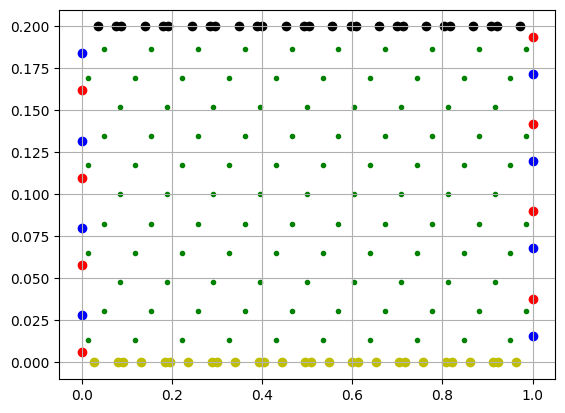

In [5]:
for n in left_x:
    n['type'] = 'left_x'
    plt.scatter(n['s'], n['t'], color='b')

for n in left_y:
    n['type'] = 'left_y'
    plt.scatter(n['s'], n['t'], color='r')

for n in right_x:
    n['type'] = 'right_x'
    plt.scatter(n['s'], n['t'], color='b')

for n in right_y:
    n['type'] = 'right_y'
    plt.scatter(n['s'], n['t'], color='r')

for n in start_x:
    n['type'] = 'start_x' 
    plt.scatter(n['s'], n['t'], color='y')
for n in start_y:
    n['type'] = 'start_y' 
    plt.scatter(n['s'], n['t'], color='y')

for n in final_x:
    n['type'] = 'final_x'
    plt.scatter(n['s'], n['t'], color='k')
for n in final_y:
    n['type'] = 'final_y'
    plt.scatter(n['s'], n['t'], color='k')

for n in center_node:
    n['type'] = 'center'
    plt.scatter(n['s'], n['t'], color='g', marker='.')

plt.grid()

# Сортировка узлов по времени
Гарантирует, что все нужные узлы будут расчитаны

In [6]:
hyp_mesh.sort(key=lambda n: n['t'])

In [7]:
from typing import Tuple
def center_solve(s:float, t:float,
                    sl:float, tl:float, xl:float, yl:float, hl:float, 
                    sr:float, tr:float, xr:float, yr:float, hr:float) -> Tuple[float, float]:
                
    A = [[1 - hr/2*B11(s, t), -hr/2*B12(s, t)],
         [-hl/2*B21(s, t), 1-hl/2*B22(s, t)]]
    b = [xr + hr/2*(B11(sr, tr)*xr+B12(sr, tr)*yr + F1(s, t) + F1(sr, tr)),
         yl + hl/2*(B21(sl, tl)*xl+B22(sl, tl)*yl + F2(s, t) + F2(sl, tl))]
    return np.linalg.solve(A, b)

def solver(mesh):
    for n in mesh:
        cord = (n['s'], n['t'])
        if n['type'] == 'start_x' or n['type'] == 'start_y':
            val = [x0(n['s']), y0(n['s'])]
            hyp.add_cord_val(cord, val)
            n['x'] = val
        elif n['type'] == 'left_y' or n['type'] == 'left_x':
            # f = left_block(coord=n['t'])
            if not cord in hyp.rez:
                hyp.add_cord_val(cord, [x_an(*cord), y_an(*cord)])
                n['x'] = [x_an(*cord), y_an(*cord)]
        elif n['type'] == 'right_x' or n['type'] == 'right_y':
            # f = right_block(coord=n['t'])
            if not cord in hyp.rez:
                hyp.add_cord_val(cord, [x_an(*cord), y_an(*cord)])
                n['x'] = [x_an(*cord), y_an(*cord)]
        elif n['type'] == 'center':
            # Проблема получения индексов (или вот этих необходимых расчетных элементов)
            # Нужен интерфейс, который бы позволил делать шаг назад вдоль характеристики 
            # (при этом если эта граница, то и позволял с ней работать)
            i, j = n['ind']
            
            neg = hyp.mesher.negative_chars[j]
            pos = hyp.mesher.positive_chars[i]
           
            right_cord_node  = neg.get_node(i+1)
            left_cord_node = pos.get_node(j-1)

            
            if not cord in hyp.rez:
                try:
                
                    hl = cord[1] - left_cord_node[1]
                    hr = cord[1] - right_cord_node[1]
                    print(cord)
                    print(left_cord_node)
                    print(right_cord_node)
                    xy_left = hyp.rez[left_cord_node]
                    xy_right = hyp.rez[right_cord_node]
                    print(*xy_left, *xy_right)
                    val = center_solve(*cord,
                        *left_cord_node, *xy_left, hl, 
                        *right_cord_node, *xy_right, hr)
                    val = [val[0], val[1]]
                    
                    hyp.add_cord_val(cord, val )
                    n['x'] = val
                    # print('ok')
                    # return
                except:
                    plt.scatter(*left_cord_node, color='r')
                    plt.scatter(*right_cord_node, color='b')
                    plt.scatter(*cord, color='g')
                   
                    return
            

# Отрисовка поверхностей x(s, t) и y(s, t)

(np.float64(0.1186666666666667), np.float64(0.013333333333333336))
(np.float64(0.092), 0)
(np.float64(0.132), 0)
0 0.5842490842490842 0 0.61660777385159
(np.float64(0.22266666666666668), np.float64(0.013333333333333336))
(np.float64(0.196), 0)
(np.float64(0.236), 0)
0 0.6638795986622075 0 0.6909385113268608
(np.float64(0.32666666666666666), np.float64(0.013333333333333336))
(np.float64(0.3), 0)
(np.float64(0.34), 0)
0 0.7307692307692307 0 0.753731343283582
(np.float64(0.8466666666666667), np.float64(0.013333333333333336))
(np.float64(0.82), 0)
(np.float64(0.86), 0)
0 0.9505494505494506 0 0.9623655913978495
(np.float64(0.9506666666666667), np.float64(0.013333333333333336))
(np.float64(0.924), 0)
(np.float64(0.964), 0)
0 0.9802494802494803 0 0.9908350305498982
(np.float64(0.43066666666666664), np.float64(0.013333333333333343))
(np.float64(0.404), 0)
(np.float64(0.444), 0)
0 0.7877492877492879 0 0.8074792243767313
(np.float64(0.5346666666666666), np.float64(0.013333333333333343))
(np.floa

Text(0.5, 0.92, 'x=x(s,t)')

Error in callback <function _draw_all_if_interactive at 0x1113b2ca0> (for post_execute), with arguments args (),kwargs {}:


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

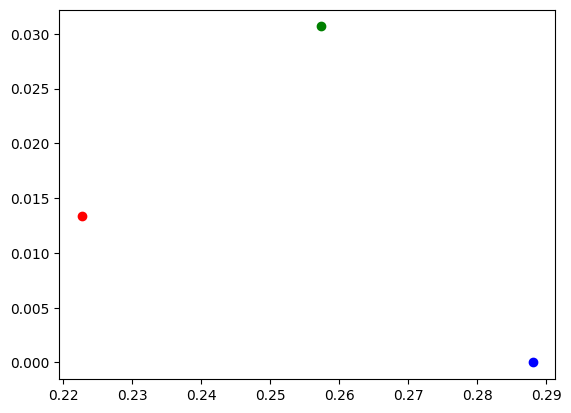

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

<Figure size 1920x1440 with 2 Axes>

In [8]:
solver(hyp_mesh)

print("OK")
figure = plt.figure(dpi=300)
ax1 = figure.add_subplot(1,2, 1, projection='3d')

for n in start_y:
    ax1.scatter(n['s'], n['t'], zs=n['x'][1], color='y', marker='.')
for n in left_y:
    ax1.scatter(n['s'], n['t'], zs=n['x'][1], color='r', marker='.')
for n in center_node:
    try:
        ax1.scatter(n['s'], n['t'], zs=n['x'][1], color='g', marker='.')
    except:
        pass
ax1.set_title('y=y(s,t)')

ax2 = figure.add_subplot(1,2, 2, projection='3d')

for n in start_x:
    ax2.scatter(n['s'], n['t'], zs=n['x'][0], color='y', marker='.')
for n in right_x:
    ax2.scatter(n['s'], n['t'], zs=n['x'][0], color='b', marker='.')

ax2.set_title('x=x(s,t)')


In [11]:
hyp.rez

{(np.float64(0.092), 0): [0, np.float64(0.5842490842490842)],
 (np.float64(0.196), 0): [0, np.float64(0.6638795986622075)],
 (np.float64(0.3), 0): [0, np.float64(0.7307692307692307)],
 (np.float64(0.404), 0): [0, np.float64(0.7877492877492879)],
 (np.float64(0.508), 0): [0, np.float64(0.8368700265251989)],
 (np.float64(0.612), 0): [0, np.float64(0.879652605459057)],
 (np.float64(0.716), 0): [0, np.float64(0.9172494172494172)],
 (np.float64(0.82), 0): [0, np.float64(0.9505494505494506)],
 (np.float64(0.924), 0): [0, np.float64(0.9802494802494803)],
 (np.float64(0.028), 0): [0, np.float64(0.5272373540856031)],
 (np.float64(0.08), 0): [0, np.float64(0.5740740740740741)],
 (np.float64(0.132), 0): [0, np.float64(0.61660777385159)],
 (np.float64(0.184), 0): [0, np.float64(0.6554054054054055)],
 (np.float64(0.236), 0): [0, np.float64(0.6909385113268608)],
 (np.float64(0.288), 0): [0, np.float64(0.7236024844720497)],
 (np.float64(0.34), 0): [0, np.float64(0.753731343283582)],
 (np.float64(0.39

In [10]:
pos.get_node(-10)

NameError: name 'pos' is not defined

In [ ]:
pos.k_left, pos.k_right

In [ ]:
hyp.rez

In [12]:
print([n['t'] for n in hyp_mesh])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, np.float64(0.006), np.float64(0.013333333333333336), np.float64(0.013333333333333336), np.float64(0.013333333333333336), np.float64(0.013333333333333336), np.float64(0.013333333333333336), np.float64(0.013333333333333343), np.float64(0.013333333333333343), np.float64(0.013333333333333343), np.float64(0.013333333333333343), np.float64(0.013333333333333364), np.float64(0.016), np.float64(0.028), np.float64(0.03066666666666666), np.float64(0.03066666666666666), np.float64(0.030666666666666675), np.float64(0.030666666666666675), np.float64(0.030666666666666675), np.float64(0.030666666666666675), np.float64(0.030666666666666675), np.float64(0.030666666666666675), np.float64(0.030666666666666675), np.float64(0.030666666666666675), np.float64(0.038), np.float64(0.04799999999999999), np.float64(0.04799999999999999), np.float64(0.04800000000000001), np.float64(0.04800000000000001), np.float64(0.0480000000000000